## **Tutorial on Muller Brown Potential**
Our objective is to observe transutions between state A and B and calculate the free energy landscape.
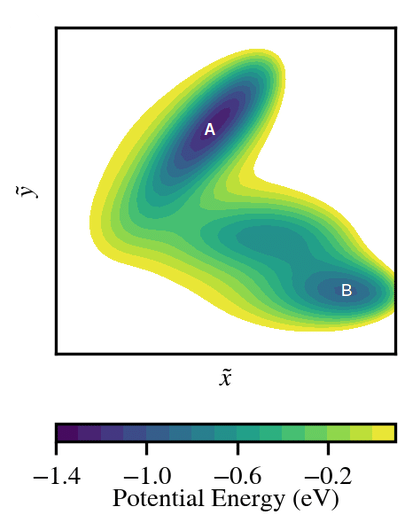

To access the zip file with pre-compiled version of plumed pytorch interface, clik here: https://drive.google.com/file/d/1VEg6CqqZUjKLqmDc1Z3ZO0KOTsWVtPnY/view?usp=sharing

After that create shortcut of this file in the MyDrive folder of your google drive.

In [6]:
#unzip precompiled version of plumed pytorch interface
from google.colab import drive
drive.mount('/content/drive')
!rm -rf gromacs_and_plumed_pytorch
!unzip /content/drive/MyDrive/gromacs_and_plumed_pytorch-20240530T140144Z-001.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t1fv_64.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t3fv_20.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t2fv_32.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t1fv_15.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t1fv_12.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t2fv_4.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwB

In [7]:
!rm -rf plumed_pytorch_tutorial
!git clone https://github.com/dhimanray/plumed_pytorch_tutorial.git

Cloning into 'plumed_pytorch_tutorial'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 57 (delta 14), reused 48 (delta 8), pack-reused 0
Receiving objects: 100% (57/57), 1.04 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [8]:
#write file to source plumed pytorch interface
sourcefile = """
#!/bin/bash
rm -r plumed2-master
ln -s gromacs_and_plumed_pytorch/plumed2-master .
chmod +x plumed2-master/*
chmod +x plumed2-master/*/*
chmod +x plumed2-master/src/lib/plumed
source plumed2-master/libtorch/sourceme.sh
source plumed2-master/sourceme.sh
"""
with open('source_plumed.sh', 'w') as file:
  file.write(sourcefile)

!chmod +x source_plumed.sh


In [22]:
path = 'plumed_pytorch_tutorial/machine_learning/mueller/'

##PES MD input file:
md_input = """
temperature 1.0
tstep 0.005
friction 10.0
dimension 2
nstep 200000
ipos -0.693111 1.40842
periodic false
"""
with open(path+'input', 'w') as file:
  file.write(md_input)

## PLUMED INPUT FILE FOR ENHANCED SAMPLING ##
plumed_input = """
UNITS NATURAL
p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ...
  ARG=p.x,p.y
  PERIODIC=NO
  FUNC=0.15*(-200*exp(-(x-1)^2-10*y^2)-100*exp(-x^2-10*(y-0.5)^2)-170*exp(-6.5*(0.5+x)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(1+x)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2)+146.7)
...
bb: BIASVALUE ARG=ff

xlwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
xuwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.0
ylwall: LOWER_WALLS ARG=p.y KAPPA=1000 AT=-0.2
yuwall: UPPER_WALLS ARG=p.y KAPPA=1000 AT=+2.0

metad: METAD ARG=p.y PACE=100 HEIGHT=1.0 SIGMA=0.1 BIASFACTOR=10 TEMP=1.0

PRINT FMT=%g STRIDE=100 FILE=COLVAR ARG=p.x,p.y,metad.*

ENDPLUMED
"""

with open(path+'plumed.dat', 'w') as file:
  file.write(plumed_input)

!source source_plumed.sh && cd plumed_pytorch_tutorial/machine_learning/mueller && plumed pesmd < input

Streaming output truncated to the last 5000 lines.
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : i

Text(0, 0.5, 'y')

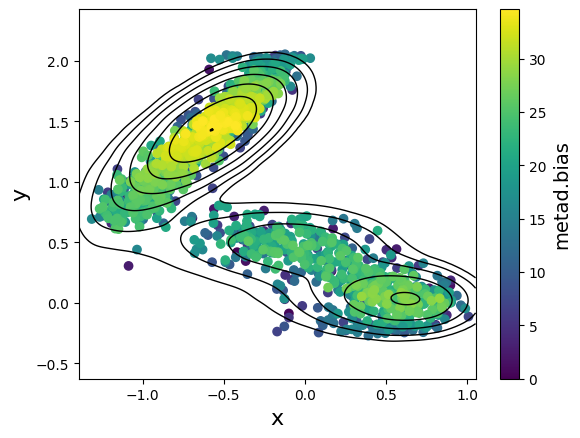

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N = 200 #number of points for plotting/interpolation

m = 40   #number of contours

x, y, z = np.genfromtxt(path+'2d_fes', unpack=True)

for i in range(len(z)):
    if z[i] >= 20.0:
        z[i] = 20
xi = np.linspace(x.min(), x.max(), N)
yi = np.linspace(y.min(), y.max(), N)
zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

X, Y = np.meshgrid(xi, yi)
plt.contour(X,Y,zi,colors='black', linewidths=1)

l = np.loadtxt(path+'COLVAR')

cp = plt.scatter(l[:,1],l[:,2],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)

plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)

Text(0, 0.5, 'x')

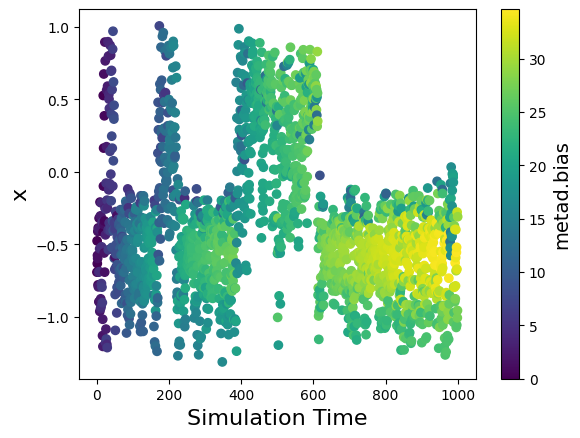

In [24]:
l = np.loadtxt(path+'COLVAR')
cp = plt.scatter(l[:,0],l[:,1],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)
plt.xlabel('Simulation Time',fontsize=16)
plt.ylabel('x',fontsize=16)

Text(0, 0.5, 'y')

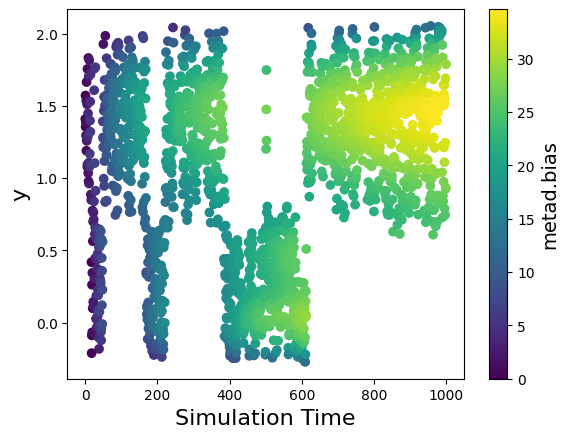

In [25]:
l = np.loadtxt(path+'COLVAR')
cp = plt.scatter(l[:,0],l[:,2],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)
plt.xlabel('Simulation Time',fontsize=16)
plt.ylabel('y',fontsize=16)

In [26]:
#Calculate 1D Free energy profile along x
!cd plumed_pytorch_tutorial/machine_learning/mueller && python FES_from_Reweighting.py --colvar COLVAR --cv p.x --kt 1.0 --sigma 0.05 -o fes_x_test


 using cv "p.x" found at column 2
 using bias "metad.bias" found at column 4
                              


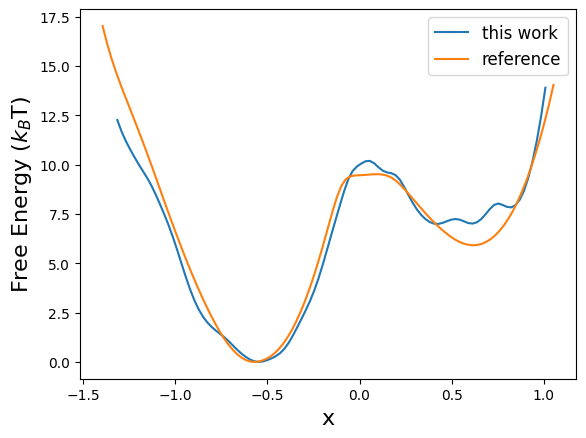

In [27]:
fes_x_test = np.loadtxt(path+'fes_x_test')
fes_x_ref = np.loadtxt(path+'fes_x')

plt.plot(fes_x_test[:,0],fes_x_test[:,1],label='this work')
plt.plot(fes_x_ref[:,0],fes_x_ref[:,1],label='reference')
plt.xlabel('x',fontsize=16)
plt.ylabel('Free Energy ($k_B$T)',fontsize=16)
plt.legend(fontsize=12)

In [28]:
#Calculate 1D Free energy profile along y axis
!cd plumed_pytorch_tutorial/machine_learning/mueller && python FES_from_Reweighting.py --colvar COLVAR --cv p.y --kt 1.0 --sigma 0.05 -o fes_y_test


 using cv "p.y" found at column 3
 using bias "metad.bias" found at column 4
                              


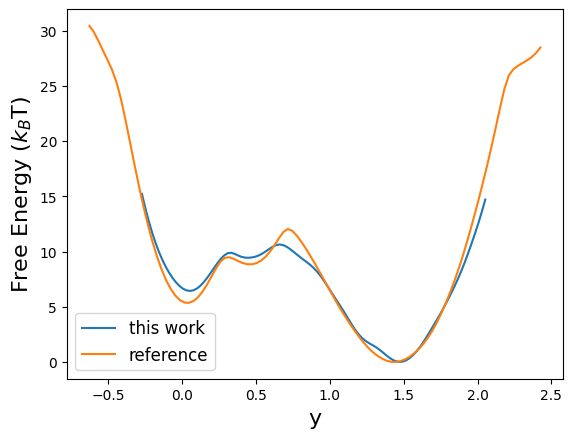

In [29]:
fes_y_test = np.loadtxt(path+'fes_y_test')
fes_y_ref = np.loadtxt(path+'fes_y')

plt.plot(fes_y_test[:,0],fes_y_test[:,1],label='this work')
plt.plot(fes_y_ref[:,0],fes_y_ref[:,1],label='reference')
plt.xlabel('y',fontsize=16)
plt.ylabel('Free Energy ($k_B$T)',fontsize=16)
plt.legend(fontsize=12)

## **Machine Learning Collective Variable Discovery: Deep-TICA**

In [36]:
#install packages
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install pytorch==2.2.2 torchvision==0.17.2 -c pytorch
!pip install mlcolvar

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...
Channels:
 - pytorch
 - conda-forge
Platform: linux-64
Solving environment: / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pytorch==2.2.2
    - torchvision==0.17.2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    blas-2.116                 |              mkl          13 KB  conda-forge
    blas-devel-3.9.0           |   16_linu

In [1]:
# IMPORT PACKAGES

import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)
print(torch.__version__)

2.2.2


In [30]:
import pandas as pd
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictModule

from google.colab import drive

path = 'plumed_pytorch_tutorial/machine_learning/mueller/'

# load colvar files containing weights of the OPES simulations as well as the driver with the input features
df = load_dataframe(path+'COLVAR',
                      start=0,stop=2000)


df

,time,p.x,p.y,metad.bias,walker
0,0.0,-0.693111,1.408420,0.00000,0
1,0.5,-0.477063,1.571160,0.00000,0
2,1.0,-0.634087,1.354260,0.09340,0
3,1.5,-0.577296,1.385880,1.11944,0
4,2.0,-0.598325,1.294740,1.43106,0
...,...,...,...,...,...
1995,997.5,-1.058960,0.744052,25.12230,0
1996,998.0,-0.672862,1.244660,32.82210,0
1997,998.5,-0.278533,1.690200,31.56700,0
1998,999.0,-1.008670,0.925235,27.20510,0


In [31]:
# Select input features
X = df.filter(regex='p.x|p.y').values
n_input = X.shape[1]

print(X.shape)

(2000, 2)


### Create time-lagged dataset

**Compute weights for time rescaling**

Here we extract the time $t$, the energy $E$ (needed for the multicanonical reweight [1]) and the bias $V$ from the COLVAR file. We then calculate the weights as:

\begin{cases}
    w = e^{\beta\ V + (\beta_0-\beta)\ E} & \text{if multicanonical}\\
    w = e^{\beta\ V}              & \text{otherwise}
\end{cases}

NB: note that if simulation temperature $\beta_0$ is equal to the reweighting one $\beta$ the multicanonical reweight coincides with the standard umbrella sampling-like case.

Once we have computed the weights, we rescale the time at step $k$ by using the instantaneus acceleration:

$$ dt'_k = w_k\ dt $$

and then compute the cumulative rescaled time:

$$ t'_k = \sum_{i=0} ^k dt'_i $$



[1] Invernizzi, Piaggi, and Parrinello. "Unified approach to enhanced sampling." _Physical Review X_ 10.4 (2020): 041034.


---

| Parameter | Type | Description |
| :- | :- | :- |
| multicanonical | bool | flag to determine if using a standard reweight (false) or a multicanonical one (true) |
| temp | float | reweighting temperature |
| temp0 | float | simulation temperature (only needed if multicanonical == True) |




In [32]:
#------------- PARAMETERS -------------
temp              = 1.0
#--------------------------------------

# Calculate inverse temperature
kb=0.008314
beta=1./(kb*temp)

# Extract cvs from df

t = df['time'].values # save time
bias = df.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

#logweights = beta*bias #Reweight with bias
logweights = 0.0*bias #Do not reweight with bias

In order to train the Deep-TICA CVs we will need to compute the time-lagged covariance matrices in the rescaled time $t'$. The standard way is to look for configurations which are distant a lag-time $\tau$ in the time series. However, in the rescaled time the time-series is _exponentially_ unevenly spaced. Hence, a naive search will lead to severe numerical issue. To address this, we use the algorithm proposed in [2]. In a nutshell, this method assume that the observable $O(t'_k)$ have the same value from scaled time $t'_k$ to $t'_{k+1}$. This leads to weighting each pair of configurations based both on the rescaled time around $t'_k$ and $t'_k+\tau$ (see supp. information of [2] for details). All of this is done under the hood in the function `find_time_lagged_configurations`. To generate the training set we use the function `create_time_lagged_dataset` which searches for the pairs of configurations and the corresponding weight.

[2] Yang and Parrinello. "Refining collective coordinates and improving free energy representation in variational enhanced sampling." _Journal of chemical theory and computation_ 14.6 (2018): 2889-2894.

---

| Parameter | Type | Description |
| :- | :- | :- |
| lag_time | float | lag_time for the calculation of the covariance matrices [in rescaled time] |
| n_train | int | number of training configurations |
| n_valid | int | number of validation configurations |


In [33]:
#------------- PARAMETERS -------------
lag_time = 1.
#--------------------------------------

# create dataset
dataset = create_timelagged_dataset(X,t,lag_time=lag_time,logweights=logweights,progress_bar=True)

# create datamodule (split train valid)
datamodule = DictModule(dataset,lengths=[0.8,0.2],random_split=False,shuffle=False)

datamodule

100%|██████████| 1996/1996 [00:00<00:00, 5422.34it/s]
/usr/local/lib/python3.10/site-packages/mlcolvar/data/datamodule.py:134: UserWarning: A torch.generator was provided but it is not used with random_split=False
  warnings.warn(


DictModule(dataset -> DictDataset( "data": [1996, 2], "data_lag": [1996, 2], "weights": [1996], "weights_lag": [1996] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=False),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=False))

### Define model

In [37]:
from mlcolvar.cvs import DeepTICA

n_components = 2
nn_layers = [n_input, 10, 10, n_components]
options= {'nn': {'activation': 'shifted_softplus'}}

model = DeepTICA(nn_layers, options=options)
model

DeepTICA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=2, out_features=2, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=10, out_features=2, bias=True)
    )
  )
  (tica): TICA(in_features=2, out_features=2)
)

### Define Trainer & Fit

In [38]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=10)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
torch.set_float32_matmul_precision('medium')
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                  | Params | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | ReduceEigenvaluesLoss | 0      | ?        | ?        
1 | norm_in | Normalization         | 0      | [2]      | [2]      
2 | nn      | FeedForward           | 162    | [2]      | [2]      
3 | tica    | TICA                  | 0      | [2]      | [2]      
-------------------------------------------------------------------------
162       Trainable params
0         Non-trainable params
162       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

We can monitor how the individual eigenvalues are optimized during training.

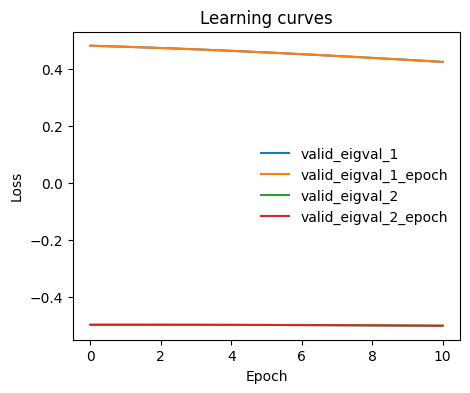

In [39]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics,
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Normalize output

For convenience, we standardize the CVs to be between -1 and 1.

In [40]:
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics

#X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) )
model.postprocessing = norm

### Compute FES

We can plot the free energy profile along the selected CVs. First we compute it in the 2D space, from which we learn that the first TICA refers to the transition between two long-lived metastable states, while the second the faster transitions within the left basin.

Text(0, 0.5, 'Deep-TICA 2')

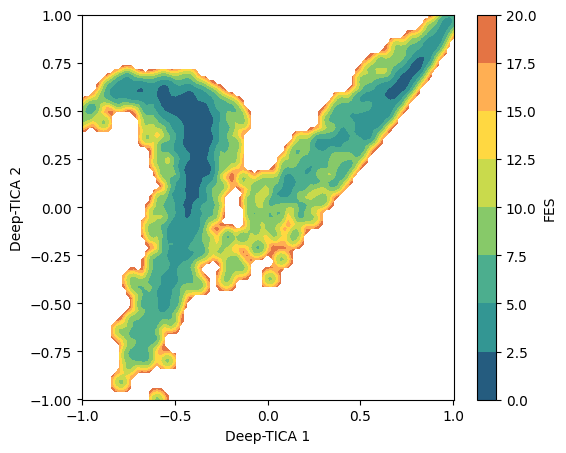

In [41]:
from mlcolvar.utils.fes import compute_fes

fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

w = np.exp(logweights)
fes,grid,bounds,error = compute_fes(s,
                                    weights=w,
                                    blocks=1,
                                    bandwidth=0.01, scale_by='range',
                                    plot=True, plot_max_fes=20, ax = ax, eps=1e-10)

ax.set_xlabel('Deep-TICA 1')
ax.set_ylabel('Deep-TICA 2')

We can also plot the free energy profiles along each component. From the 2D FES above we understand that for the second CV we need to compute the FES only for the points in which the first CV is < 0, in order to describe the barrier between the faster states.

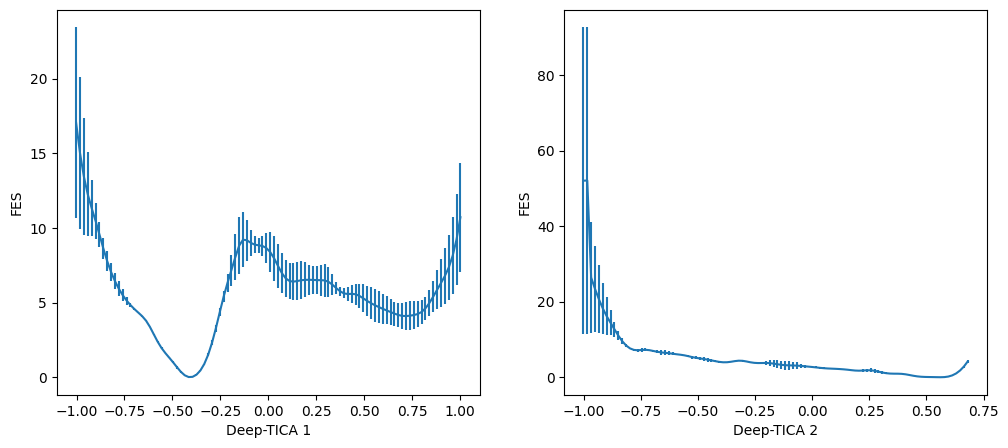

In [42]:
from mlcolvar.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(6*n_components,5),dpi=100)

for i in range(n_components):
    w = np.exp(logweights)

    # restrict the second CV to the points in which the first is < 0
    fes,grid,bounds,error = compute_fes(s[:,i] if i == 0 else s[s[:,0] < 0, i ],
                                        weights=w if i == 0 else w[s[:,0] < 0 ],
                                        blocks=2,
                                        bandwidth=0.02,scale_by='range',
                                        plot=True, plot_max_fes=100, ax = axs[i])
    axs[i].set_xlabel('Deep-TICA '+str(i+1))

Note that the huge uncertainty on the free energy barrier is due to the lack of points between the states in the multithermal simulation.

### Plot CVs isolines in x-y space

To understand to what states the CVs refer to, we can visualize them in the x-y space.

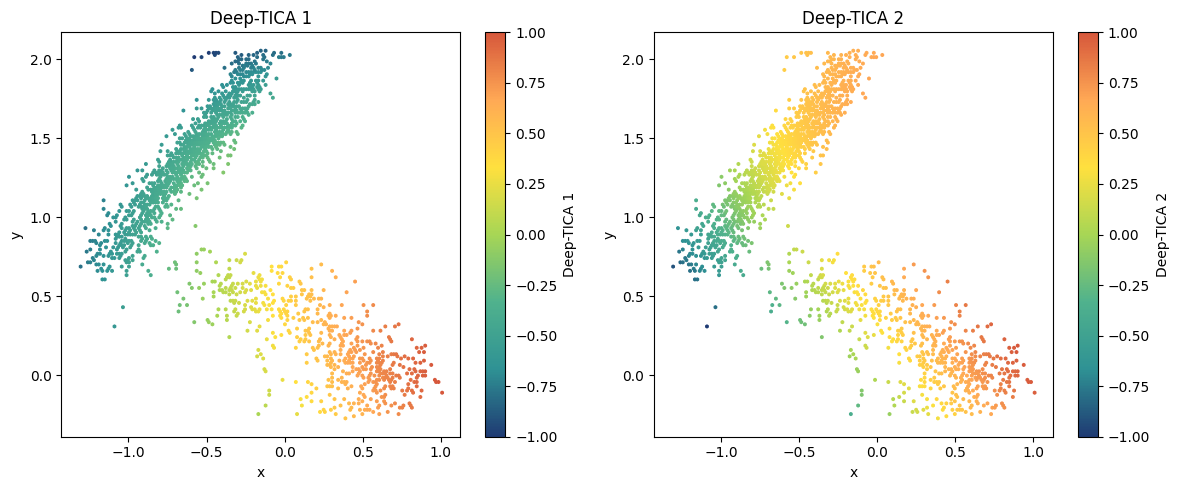

In [43]:
# Hexbin plot in physical space
fig,axs = plt.subplots(1,n_components,figsize=(6*n_components,5),dpi=100)

x = df['p.x'].values
y = df['p.y'].values

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap='fessa')
    cbar = plt.colorbar(pp,ax=ax)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

In [44]:
## Save the model
x = torch.rand(n_input, dtype=torch.float32, requires_grad=True).unsqueeze(0)
traced_cv = torch.jit.trace ( model, example_inputs=x)
filename=path+'model_deeptica.pt'
traced_cv.save(filename)

/usr/local/lib/python3.10/site-packages/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()
/usr/local/lib/python3.10/site-packages/torch/jit/_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403233856/work/build/aten/src/ATen/core/Ten

## **Run Enhanced Sampling Simulation with Machine Learning CV**

In [58]:
import os
mlpath = 'plumed_pytorch_tutorial/machine_learning/mueller_mlcv/'
os.system('rm -rf %s'%mlpath)
os.system('mkdir %s'%mlpath)
os.system('cp %smodel_deeptica.pt %s'%(path,mlpath))

##PES MD input file:
md_input = """
temperature 1.0
tstep 0.005
friction 10.0
dimension 2
nstep 200000
ipos -0.693111 1.40842
periodic false
"""
with open(mlpath+'input', 'w') as file:
  file.write(md_input)

## PLUMED INPUT FILE FOR ENHANCED SAMPLING ##
plumed_input = """
UNITS NATURAL
p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ...
  ARG=p.x,p.y
  PERIODIC=NO
  FUNC=0.15*(-200*exp(-(x-1)^2-10*y^2)-100*exp(-x^2-10*(y-0.5)^2)-170*exp(-6.5*(0.5+x)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(1+x)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2)+146.7)
...
bb: BIASVALUE ARG=ff

xlwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
xuwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.0
ylwall: LOWER_WALLS ARG=p.y KAPPA=1000 AT=-0.2
yuwall: UPPER_WALLS ARG=p.y KAPPA=1000 AT=+2.0

deepTICA: PYTORCH_MODEL FILE=model_deeptica.pt ARG=p.x,p.y

metad: METAD ARG=deepTICA.node-0 PACE=100 HEIGHT=1.0 SIGMA=0.1 BIASFACTOR=10 TEMP=1.0

PRINT FMT=%g STRIDE=100 FILE=COLVAR ARG=p.x,p.y,metad.bias,deepTICA.node-0

ENDPLUMED
"""

with open(mlpath+'plumed.dat', 'w') as file:
  file.write(plumed_input)

!source source_plumed.sh && cd plumed_pytorch_tutorial/machine_learning/mueller_mlcv && plumed pesmd < input

Streaming output truncated to the last 5000 lines.
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : input requested but this quantity has not been set 
PLUMED: WARNING for action PBC with label Box : i

Text(0, 0.5, 'y')

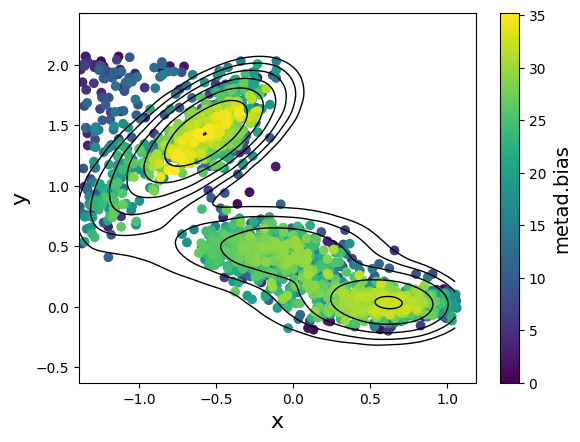

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N = 200 #number of points for plotting/interpolation

m = 40   #number of contours

x, y, z = np.genfromtxt(path+'2d_fes', unpack=True)

for i in range(len(z)):
    if z[i] >= 20.0:
        z[i] = 20
xi = np.linspace(x.min(), x.max(), N)
yi = np.linspace(y.min(), y.max(), N)
zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

X, Y = np.meshgrid(xi, yi)
plt.contour(X,Y,zi,colors='black', linewidths=1)

l = np.loadtxt(mlpath+'COLVAR')

cp = plt.scatter(l[:,1],l[:,2],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)

plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)

Text(0, 0.5, 'x')

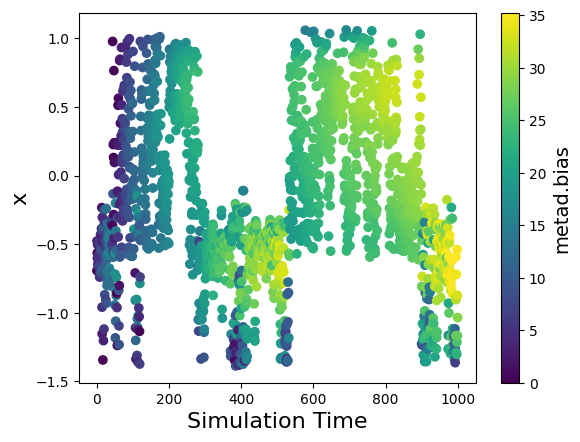

In [48]:
l = np.loadtxt(mlpath+'COLVAR')
cp = plt.scatter(l[:,0],l[:,1],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)
plt.xlabel('Simulation Time',fontsize=16)
plt.ylabel('x',fontsize=16)

Text(0, 0.5, 'y')

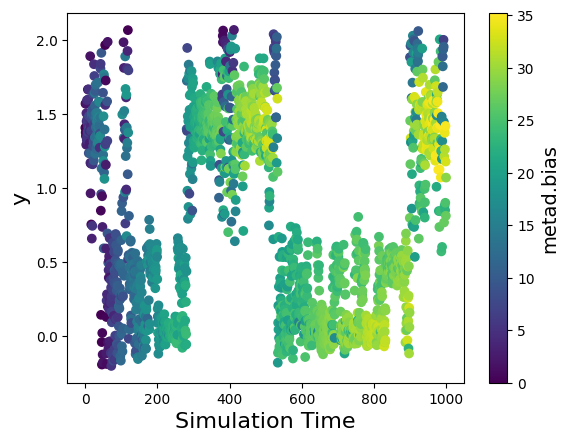

In [49]:
l = np.loadtxt(mlpath+'COLVAR')
cp = plt.scatter(l[:,0],l[:,2],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)
plt.xlabel('Simulation Time',fontsize=16)
plt.ylabel('y',fontsize=16)

Text(0, 0.5, 'Deep TICA CV')

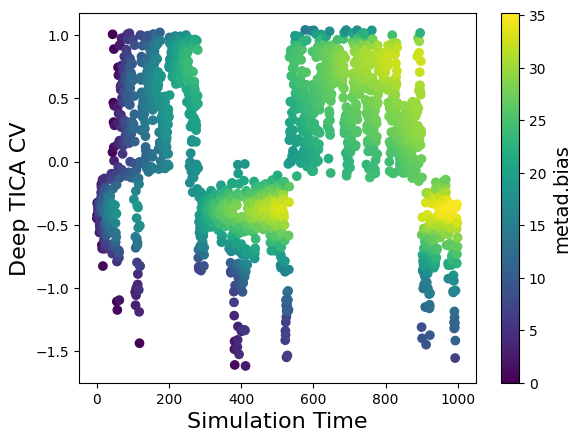

In [60]:
l = np.loadtxt(mlpath+'COLVAR')
cp = plt.scatter(l[:,0],l[:,4],c=l[:,3])
cbar = plt.colorbar(cp)
cbar.set_label('metad.bias',fontsize=14)
plt.xlabel('Simulation Time',fontsize=16)
plt.ylabel('Deep TICA CV',fontsize=16)

In [61]:
#Calculate 1D Free energy profile along x
!cd plumed_pytorch_tutorial/machine_learning/mueller_mlcv && python ../mueller/FES_from_Reweighting.py --colvar COLVAR --cv p.x --kt 1.0 --sigma 0.05 -o fes_x_test


 using cv "p.x" found at column 2
 using bias "metad.bias" found at column 4
                              


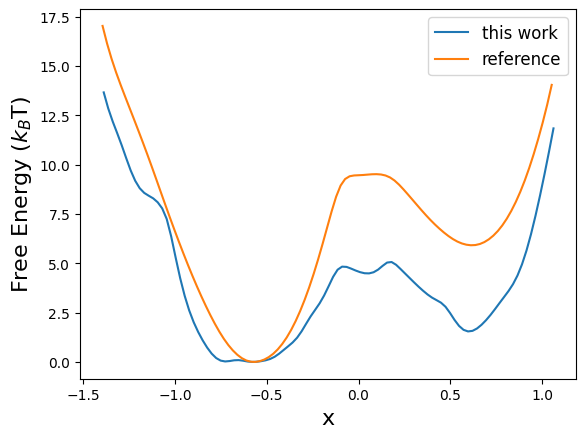

In [62]:
fes_x_test = np.loadtxt(mlpath+'fes_x_test')
fes_x_ref = np.loadtxt(path+'fes_x')

plt.plot(fes_x_test[:,0],fes_x_test[:,1],label='this work')
plt.plot(fes_x_ref[:,0],fes_x_ref[:,1],label='reference')
plt.xlabel('x',fontsize=16)
plt.ylabel('Free Energy ($k_B$T)',fontsize=16)
plt.legend(fontsize=12)

In [55]:
#Calculate 1D Free energy profile along y axis
!cd plumed_pytorch_tutorial/machine_learning/mueller_mlcv && python ../mueller/FES_from_Reweighting.py --colvar COLVAR --cv p.y --kt 1.0 --sigma 0.05 -o fes_y_test


 using cv "p.y" found at column 3
 using bias "metad.bias" found at column 4
                              


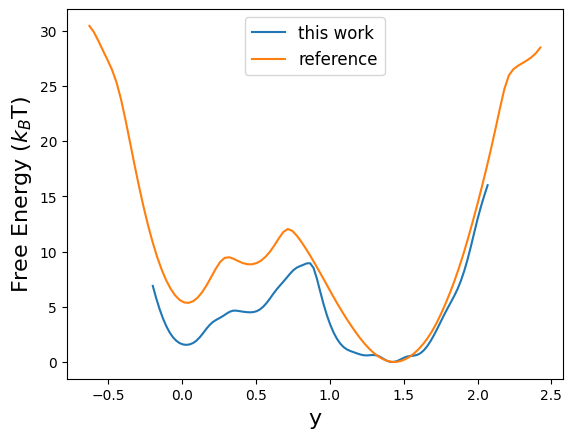

In [56]:
fes_y_test = np.loadtxt(mlpath+'fes_y_test')
fes_y_ref = np.loadtxt(path+'fes_y')

plt.plot(fes_y_test[:,0],fes_y_test[:,1],label='this work')
plt.plot(fes_y_ref[:,0],fes_y_ref[:,1],label='reference')
plt.xlabel('y',fontsize=16)
plt.ylabel('Free Energy ($k_B$T)',fontsize=16)
plt.legend(fontsize=12)